# Sprint 2

This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet.

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

During `sprint 1` we created a classifier that for the message of the customers based on the product.

During `sprint 2` we attempt to do the same using clustering by unsupervised learning instead of supervised classification.

In [2]:
# downloads and installs
import sys
!conda install --yes --prefix {sys.prefix} nltk bs4 gensim
!conda install --yes --prefix {sys.prefix} -c conda-forge hdbscan
import nltk
nltk.download('stopwords')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import re
import string
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.sklearn_api import D2VTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples

from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN

# 1. EDA

All EDA steps were performed during `sprint 1`.

# 2. Preprocessing


In order to address the problems of the data, we prepared our data.


## 2.1. Read

In [4]:
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

Having the data allows us to create some constants:

In [5]:
# Basic constants
SAMPLE_AMOUNT = 10000
VISUAL_AMOUNT = 5000
PRODUCT_AMOUNT = len(set(complaints['Product']))

## 2.2. Sampling

Let's now take a sample from this set that shall be used during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 10000. 

A fixed seed is also added so that the same sample is produced every time. We do this in order to keep consistency when running hte notebook several times over and over but it's not stictly needed. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

In [6]:
data = complaints.sample(SAMPLE_AMOUNT, random_state=7844569)

## 2.3. Text cleaning

We learned from `sprint 1` that cleaning the text is very important. We only applied this in the final phases of `sprint 1`. However, we decided to learn from our mistakes and do this right away during this sprint.
We can clearly see the text contains special characters, numbers, anonymized data, html, etc...
This needed to be dealt with.

In [7]:
pd.set_option('max_colwidth', None)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
234227,"Credit reporting, credit repair services, or other personal consumer reports","XXXX XXXX XXXX XXXX XXXX XXXX XXXX CA XXXX SSN : XXXX Experian XXXX. XXXX XXXX XXXX, TX XXXX According to the Fair Credit Reporting Act, you are required by federal law to verify-through the physical verification of the original signed consumer contract -any and all accounts you post on a credit report. Otherwise, anyone paying for your reporting services could fax, mail or email in a fraudulent account. \nI demand to see the Verifiable Proof ( an original Consumer Contract with my Signature on it ) you have on file of the accounts listed below. Your failure to positively verify these accounts has hurt my ability to obtain credit. Under the FCRA, unverified accounts must be removed and if you are unable to provide me a copy of verifiable proof, you must remove the accounts listed below. \nI demand the following accounts be verified or removed immediately Name of Account XXXX XXXX XXXX Provide Physical Verification Creditor 1 XXXX C/O XXXX XXXX XXXX UNKOWN XXXX XXXX XXXX XXXX, SC XXXX"
482889,"Credit reporting, credit repair services, or other personal consumer reports","I recently received a letter from Equifax dated XX/XX/2018 stating that 'We have received your request concerning a security freeze on your Equifax credit report. Unfortunately, we were unable to process your request because we need additional information. ' Then the letter requests that I submit items to validate my identity and address. \nI have made no recent requests to Equifax concerning my security freeze. \nMy security freeze should be current and in place. \n\nI do not know why Equifax sent me this letter claiming that I made a request concerning a security freeze when I did not."
23996,Mortgage,"I have been with Lakeview Loan Servicing/XXXX XXXX XXXX XXXX ( hereafter referred to as "" XXXX '' ). Mortgage for three years. I recently made the decision to refinance and thus change mortgage companies and homeowner 's insurance companies. XXXX is responsible for paying my homeowner 's insurance from my escrow account and has done so without issue in the past. Recently, they allowed my insurance policy to lapse for non-payment. The company was notified of the pending cancellation via letter from XXXX XXXX. Prior to this happening, I had called to notify them of the change of insurance companies and provided them with the necessary information to continue making payments. It was only once I received notification from the new insurance company ( XXXX XXXX ) and the refinance company ( XXXX XXXX ) that I was made aware that the policy had not been paid. Not only was this holding up my refinance but the policy was due for cancellation. I immediately contacted the insurance company and was told that the payment needed to be sent overnight. I contacted XXXX and was assured that the payment would be sent via overnight. Days later, I was notified by XXXX XXXX that the policy had still not been paid. I called XXXX again and was told that the payment had in fact not been sent because the representative I had spoken to did not provide "" adequate documentation '' when making the requests for payment. Instead of XXXX notifying me that they payment was not paid, they simply ignored it and allowed my policy to lapse ( unbeknownst to me ). \nWhile this may appear to be simply a careless mistake, I am convinced that since I had made a decision to go with a different mortgage company, XXXX maliciously and intentionally neglected to pay my homeowner 's insurance. I am requesting that this incident be investigated."
55010,Debt collection,I rented a apartment at XXXX XXXX XXXX XXXX It was unit # XXXX. Upon repeated harassment from tenants below us I decided to move after the women who lived there tried to force their way into my unit. I called management repeatedly and was told it is a personal matter. After I felt unsafe I left on XXXX fearing for mine a

We created a function filtering out the following unwanted things:
- html
- anonymized data
- numbers
- uppercase
- stopwords

We first tried lemmatization but this did not change much that's why we decided to use a harsher stemming approach.

In [8]:
stopWords = stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
  
def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [9]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)
data[['Product','Consumer complaint narrative']].head()

,Product,Consumer complaint narrative
234227,"Credit reporting, credit repair services, or other personal consumer reports",ca ssn experian tx accord fair credit report act requir feder law verifythrough physic verif origin sign consum contract ani account post credit report otherwis anyon pay report servic could fax mail email fraudul account demand see verifi proof origin consum contract signatur file account list failur posit verifi account hurt abil obtain credit fcra unverifi account must remov unabl provid copi verifi proof must remov account list demand follow account verifi remov immedi name account provid physic verif creditor co unkown sc
482889,"Credit reporting, credit repair services, or other personal consumer reports",recent receiv letter equifax date state receiv request concern secur freez equifax credit report unfortun unabl process request becaus need addit inform letter request submit item valid ident address made recent request equifax concern secur freez secur freez current place know whi equifax sent letter claim made request concern secur freez
23996,Mortgage,lakeview loan servic hereaft refer mortgag three year recent made decis refin thus chang mortgag compani homeown insur compani respons pay homeown insur escrow account done without issu past recent allow insur polici laps nonpay compani notifi pend cancel via letter prior happen call notifi chang insur compani provid necessari inform continu make payment onli onc receiv notif new insur compani refin compani made awar polici paid onli hold refin polici due cancel immedi contact insur compani told payment need sent overnight contact assur payment would sent via overnight day later notifi polici still paid call told payment fact sent becaus repres spoken provid adequ document make request payment instead notifi payment paid simpli ignor allow polici laps unbeknownst may appear simpli careless mistak convinc sinc made decis go differ mortgag compani malici intent neglect pay homeown insur request incid investig
55010,Debt collection,rent apart unit upon repeat harass tenant us decid move women live tri forc way unit call manag repeat told person matter felt unsaf left fear mine daughter safeti debt turn collect agenc rent paid leas collect agenc contact demand take care debt point major issu rent paid owe non payment transact bank statement leas yet say owe day rent paid carpet damag walk report bad damag fray move mos never receiv ani inform item bill anyon yet tri collect debt build non smoke build constant smoke blown unit stair balconi door vent bathroom leas say prohibit activ threaten behavior disturb safeti im women tri forc way unit call manag offic sever time tell repeat bulli harass told person matter
212855,"Credit reporting, credit repair services, or other personal consumer reports",credit repor ting agenc report inaccuraci credit report disput inform ask inform nt provid address never resid credit report suggest along unknown address numer account credit report open ask credit bureaus look disput inform correct inaccuraci noth done inform hurt credit score nd credit report hold back thing need


After applying the function to the whole column, we can see the results are as expected.

## 2.4. Feature Extraction

In order for the computer to understand the customers complaints we needed to use Natural Language Processing techniques. We need to extract features from the messages.

### TF-IDF

We chose TF-IDF for its normalization features instead of using a simple bag of words. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document." This seemed very useful in our case since mails generally follow a fixed pattern and use rather similar vocabulary.

In [10]:
def tfidf():
    tfidf = TfidfVectorizer()
    transformed = tfidf.fit_transform(data['Consumer complaint narrative'])
    print(f'Resulting shape: {transformed.shape}')
    return transformed

### Doc2Vec

We tested Doc2Vec aswell and considered every mail as a document. We hoped this would locate corresponding emails close to eachother. 

In [11]:
def doc2vec():
#     documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
#     model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4)
#     model.build_vocab(documents)
#     model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    
#     transformed = []
#     for doc in documents:
#         transformed.append(model.infer_vector(doc.words, epochs=model.epochs))
    
#     transformed = np.asarray(transformed)
#     print(f'Resulting shape: {transformed.shape}')
    
    docsAsListOfStrings = [doc for i, doc in enumerate(row.split() for row in data['Consumer complaint narrative'])]
    model = D2VTransformer(size=20, window=2, min_count=1, workers=4, )
    transformed = model.fit_transform(docsAsListOfStrings)
    return transformed

In [18]:
# Chosen FE technique:
transformed = doc2vec()

## 2.5. Dimensionality Reduction

### Truncated SVD

Since TF-IDF works with a sparse matrix we used TSVD to reduce the dimensions. 

In [13]:
def tsvd(n):
    svd = TruncatedSVD(n_components=n)
    reduced = svd.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

### PCA

We noticed that TSVD in combination with Doc2Vec was not optimal for this use case, all points were located very close to eachother. Instead we tried PCA and found minor improvement.

In [14]:
def pca(n):
    pca = PCA(n_components=n)
    reduced = pca.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

### TSNE

Because we weren't satisfied with the results PCA and TSVD and our goal is visualization we decided to try TSNE. Language data is high in dimensions. TSNE is a better projection of multidimensional space onto two dimensional space than PCA. 

In [15]:
def tsne(n):
    tsne = TSNE(n_components=n)
    reduced = tsne.fit_transform(transformed)
    print(f'Resulting shape: {reduced.shape}')
    return reduced

In [16]:
# chosen DR technique:
reduced = tsne(2)

Resulting shape: (10000, 2)


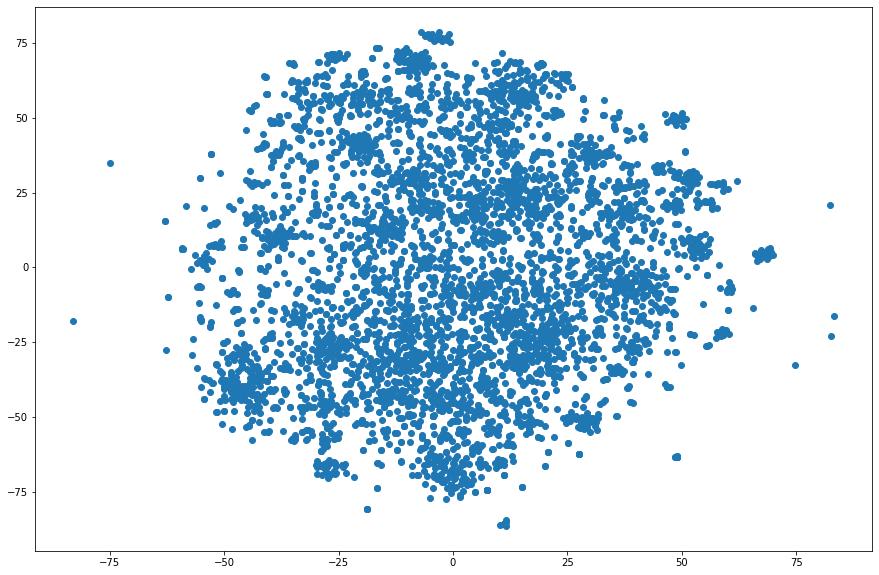

In [17]:
y = data['Product']
x = reduced
plt.figure(figsize=(15,10))
plt.scatter(x[:VISUAL_AMOUNT,0], x[:VISUAL_AMOUNT,1])

# 3. Kmeans Clustering

Since we have a rough idea of how many clusters we would expect (because we already simplified the data) we decided first to try Kmeans clustering with the same number of clusters as we created our own categories.

In [19]:
# ordered list of all products
products = list(set(complaints['Product']))
products.sort()

In [20]:
kmeans = KMeans(n_clusters=PRODUCT_AMOUNT)
predictions = kmeans.fit_predict(x)

## 3.1. Initial Analysis

We can immediately check if the found clusters are similar to the labels of ground truth. However matching the labels with a cluster is not as easy. We can only validate this by looking at pairs of records, and seeing if pairs that had the same label are in the same cluster.

TP, FP, TN, FN are normally terms from supervised learning. In literature, they also seem to used for external validation with unsupervised algorithms.

In [23]:
def calculateStatistics(ground_labels, predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
   
    #check all pairs 
    for i in range(len(ground_labels)):
        for j in range(i+1, len(ground_labels)):
            # if they belong to the same cluster in round truth
            if ground_labels[i] == ground_labels[j]:
                # did they also match the same cluster from kmeans?
                if predicted[i] == predicted[j]:
                    TP = TP + 1
                else:
                    FN = FN + 1
            else:
                if predicted[i] == predicted[j]:
                    FP = FP + 1
                else:
                    TN = TN + 1
    return TP, FP, TN, FN

def printStatistics(TP, FP, TN, FN):
    print("TP : " + str(TP))
    print("TN : " + str(TN))
    print("FP : " + str(FP))
    print("FN : " + str(FN))
    print("right: " + str(TP + TN))
    print("wrong: " + str(FN + FP))
    print("rand index: " + str((TP + TN)/(FN + FP + TP + TN)))
    print("precision over all clusters: " + str(TP/(TP + FP)))
    print("recall over all clusters: " + str(TP/(TP + FN)))

In [24]:
ground_labels = [products.index(p) for p in y]

In [25]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)
printStatistics(TP, FP, TN, FN)

TP : 1128110
TN : 39949147
FP : 1713437
FN : 7204306
right: 41077257
wrong: 8917743
rand index: 0.8216273027302731
precision over all clusters: 0.39700557478021653
recall over all clusters: 0.13538810352243574



The rand index would indicate that it seems to perform very well, however this is simply not true. It is dominated by the amount of TN of which there naturally are a lot, given the amount of clusters. 

Changing nothing we get a precision of about 40%. Considering the fact a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%) we are at least doing better than random. But we don't consider 40% as sufficient. The recall is very bad in it's own right. We asked ourselves why this could be? The main reasons we decided to explore further were:

- our arbitrary number of categories was wrong, the machine could possibly be right
- a general lack of hyperparameter tuning

When we look at a sample we don't even see indications of clusters:

In [26]:
# Create the amount of random colors required
def create_colors(n):
    colormap = []
    for i in range(n):
        colormap.append(np.random.rand(3,))
    return colormap

In [27]:
colormap=create_colors(PRODUCT_AMOUNT)
product_indices = list(map(lambda x : products.index(x), y[:VISUAL_AMOUNT]))

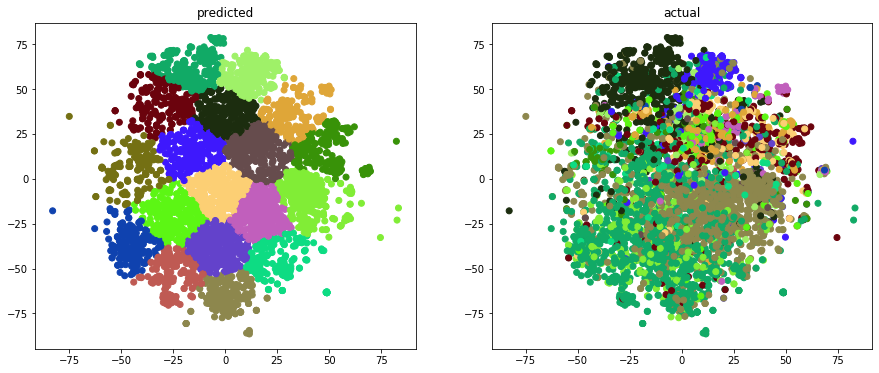

In [28]:
def compare_visually(x_train, predictions, product_indices, colormap):
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('predicted')
    ax1.scatter(x_train[:VISUAL_AMOUNT,0], x_train[:VISUAL_AMOUNT,1], c=[colormap[i] for i in predictions[:VISUAL_AMOUNT]])

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('actual')
    ax2.scatter(x_train[:VISUAL_AMOUNT,0], x_train[:VISUAL_AMOUNT,1], c =[colormap[i] for i in product_indices])
    
compare_visually(x, predictions, product_indices, colormap)

We can see that k-means find clusters. However we see that the data itself is not clustered according to products nicely when we set the amount of clusters to 18 (= the amount of products given). We decided to see if a different value of clusters made more sense.

## 3.2. Determing K

We determined K using the elbow method and silhouette analysis.

In [29]:
def silhouette(k):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-04,random_state=0)
    y_km = km.fit_predict(x)

    import numpy as np
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper),
               c_silhouette_vals,
               height=1.0,
               edgecolor='none',
               color=color)
      yticks.append((y_ax_lower + y_ax_upper) / 2.)
      y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

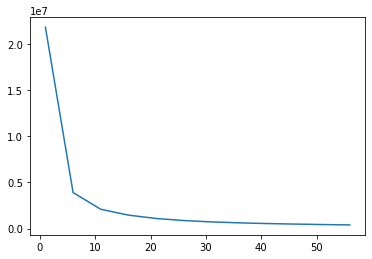

In [30]:
def elbow(start, end, step):
    oplossingen = []
    for i in range(start,end,step):
        kmeans = KMeans(n_clusters=i, init='k-means++')
        kmeans.fit(x)
        oplossingen.append(kmeans.inertia_)
    plt.plot(range(start,end,step),oplossingen)
    
elbow(1,60,5)

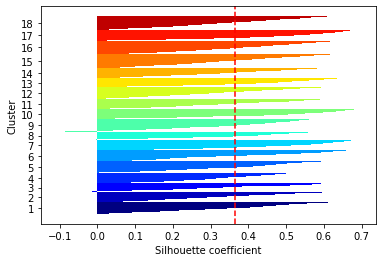

In [31]:
silhouette(PRODUCT_AMOUNT)

Silouhette analysis shows us that it actually does a fairly descent job. 

This elbow analysis indicates that a smaller K value would be more interesting. In `sprint 1` during the EDA phase we actually noticed that the product column was very overlapping at times. That is why we simplified the 18 categories to 6 categories. The elbow analysis seems to suggest that this was the right move. We take a more detailed look:

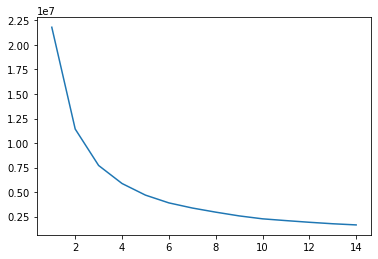

In [32]:
elbow(1,15,1)

The second elbow seems to confirm what we found during `sprint 1`. We check with an other silhouette analysis if this would be valid:

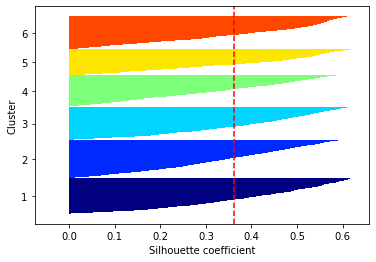

In [33]:
silhouette(6)

Using the values of k indicated by the elbow method, we can plot the average silhouette coefficient to get a better idea for which value of k is a good value.

In [34]:
def silhouetteavgs(X,no_clusters):
    km = KMeans(n_clusters=no_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04)
    y_km = km.fit_predict(X)
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    silhouette_avg = np.mean(silhouette_vals)
    return silhouette_avg

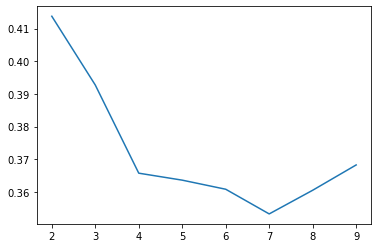

In [36]:
avgs = []
for i in range(2,10):
    avgs.append(silhouetteavgs(x, i))

plt.plot(range(2,10), avgs)

## 3.3. TFIDF + TSNE + Kmeans: 6 clusters

Since we found 6 clusters to be more appropriate according to elbow analysis we decided to implement this model.
We train the model with 6 clusters in order to check for improvement:

In [37]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(x)

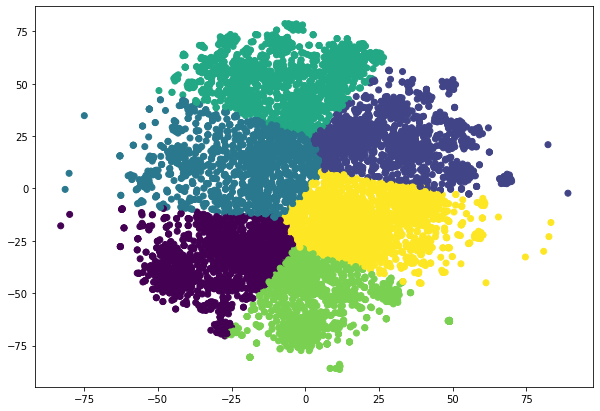

In [39]:
plt.figure(figsize=(10,7))
plt.scatter(x[:,0],x[:,1],c=predictions)

In [40]:
def compareLabelsWithProducts(cluster_labels, print_=False):
    labeled = data.copy()
    labeled['LABEL'] = cluster_labels
    targets = np.unique(labeled['Product'])
    labels = np.unique(labeled['LABEL'])
    fractions = {}
    for target in targets:
        total = np.count_nonzero(labeled['Product'] == target)
        fractions[target] = [None] * len(labels)
        for label in labels:
            is_target = labeled['Product'] == target
            is_label = labeled['LABEL'] == label
            match = labeled[is_target & is_label]
            fractions[target][label] = match.shape[0]/total

    as_list = []
    for key in fractions:
        row = []
        row.append(key)
        print_ and print(key)
        for value in fractions[key]:
            row.append(value)
            print_ and print("\t" + str(value))
        as_list.append(row)
        
    df = pd.DataFrame(as_list, columns=['Product', *labels])
    df['LabelMax'] = df.iloc[:,1:].idxmax(axis=1)
    return df

In [43]:
df = compareLabelsWithProducts(predictions)
df = df.sort_values(by='LabelMax')
df

,Product,0,1,2,3,4,5,LabelMax
6,"Credit reporting, credit repair services, or other personal consumer reports",0.385378,0.035190,0.163307,0.033823,0.288350,0.093953,0
5,Credit reporting,0.481422,0.024233,0.119548,0.012924,0.248788,0.113086,0
0,Bank account or service,0.018072,0.656627,0.162651,0.114458,0.018072,0.030120,1
14,Prepaid card,0.000000,0.580645,0.322581,0.000000,0.000000,0.096774,1
11,Other financial service,0.200000,0.600000,0.200000,0.000000,0.000000,0.000000,1
9,Money transfers,0.032258,0.870968,0.000000,0.064516,0.000000,0.032258,1
8,"Money transfer, virtual currency, or money service",0.013423,0.906040,0.040268,0.033557,0.006711,0.000000,1
3,Credit card,0.051913,0.598361,0.122951,0.106557,0.043716,0.076503,1
1,Checking or savings account,0.002717,0.728261,0.122283,0.108696,0.010870,0.027174,1
4,Credit card or prepaid card,0.044709,0.590164,0.172876,0.102832,0.029806,0.059613,1


We can see that some products clearly fit within one cluster, while some other products have more of an overlap with several clusters. For most products there is still a minor overlap with every cluster. 

By applying standard kmeans with 6 clusters. We have found that, on it's own, most products do mostly match to one cluster. 


In [44]:
TP, FP, TN, FN = calculateStatistics(ground_labels, kmeans.labels_)
printStatistics(TP, FP, TN, FN)

TP : 2975734
TN : 36188242
FP : 5474342
FN : 5356682
right: 39163976
wrong: 10831024
rand index: 0.7833578557855786
precision over all clusters: 0.3521547025139182
recall over all clusters: 0.35712739258337556


We get both a precision and a recall of 35 which is not the best but at least now both metrics are good, rather than just precision being high.

We decided to examine how our assumption from `sprint 1` performed according to this clustering:

In [45]:
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

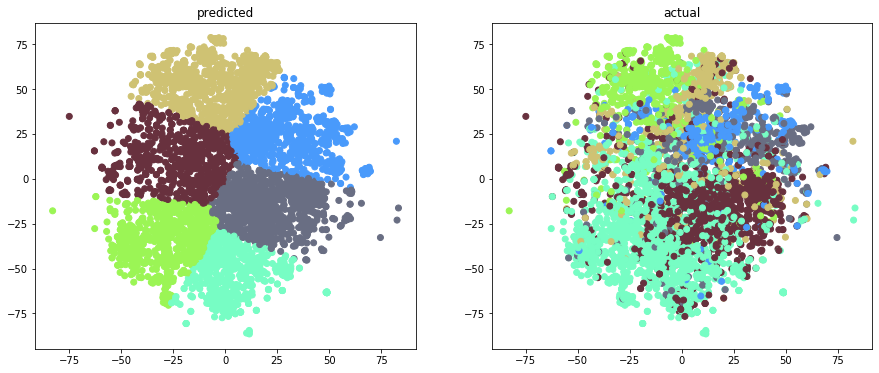

In [50]:
colormap = create_colors(6)
product_indices = list(map(lambda x : ord(simp_map[x])-ord('A'), y[:VISUAL_AMOUNT]))

compare_visually(x, predictions, product_indices, colormap)

By looking at chart that describes our simplification we still don't have clear patterns.
This lead us to believe that the clusters created with TF-IDF + TSNE + KMeans were non-sensical. 

## 3.4. Doc2Vec + TSNE + KMeans (6 clusters)

Since we can see in both cases (products or simplified products) points are very scattered we decided to try a different feature extraction technique.

In [51]:
transformed = doc2vec()

In [52]:
reduced = tsne(2)

Resulting shape: (10000, 2)


In [53]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(x)

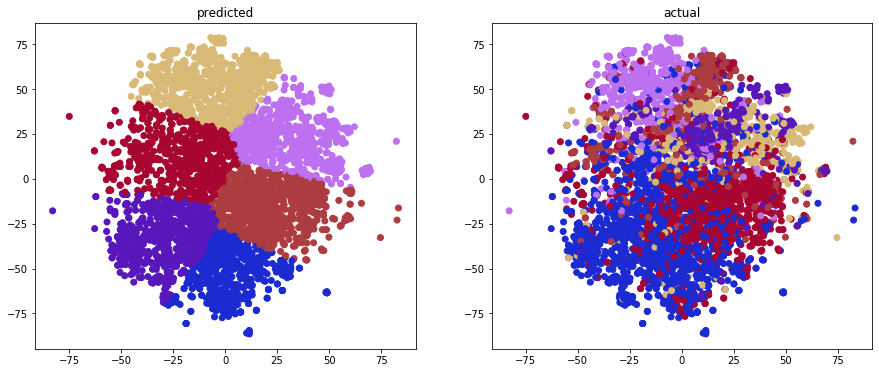

In [54]:
colormap=create_colors(6)
product_indices = list(map(lambda x : ord(simp_map[x])-ord('A'), y[:VISUAL_AMOUNT]))
compare_visually(x, predictions, product_indices, colormap)

The same problemen keeps presenting itself. Furthermore we noticed that the actual product groupings were not spherical (and Kmeans assumes this) we decided to try DBScan clustering instead because kmeans might not be fitting for the data.

# 4. DBScan Clustering

DBscan works with densities instead of distances, which allows it to model non-circular clusters. 

Let's now use DBscan and see if there's any different clusters in the data.

Here we will immediately use the reduced data from TSNE and analyze it futher. The other algorithms are also used, but we won't go into much detail. Their shorter analysis is given in 4.3

In [55]:
reduced = tsne(2)

Resulting shape: (10000, 2)


In [56]:
def printClusters(y):
    clusters = []
    for element in y:
        while len(clusters) <= element + 1:
            clusters.append(0)
        clusters[element] += 1
    for index in range(len(clusters)-1):
        print(f"cluster {index}: {clusters[index]} elements")
    print(f"outliers: {clusters[len(clusters)-1]}")

In [57]:
db = DBSCAN()
y_db = db.fit_predict(reduced)

## 4.2. Initial Analysis with TSNE

In order to see how good the model works out of the box we want to know how accurate it managed to create these clusters according to our ground truth.
Let's analyze some statistics like how many clusters there are, and how good the clustering works.

In [58]:
print("ground truth:")
printClusters(product_indices)
print("\n\nfound:")
printClusters(db.labels_)

ground truth:
cluster 0: 632 elements
cluster 1: 483 elements
cluster 2: 513 elements
cluster 3: 1807 elements
cluster 4: 466 elements
cluster 5: 1099 elements
outliers: 0


found:
cluster 0: 13 elements
cluster 1: 5 elements
cluster 2: 7 elements
cluster 3: 19 elements
cluster 4: 9 elements
cluster 5: 9 elements
cluster 6: 6 elements
cluster 7: 6 elements
cluster 8: 14 elements
cluster 9: 6 elements
cluster 10: 5 elements
cluster 11: 6 elements
cluster 12: 13 elements
cluster 13: 36 elements
cluster 14: 5 elements
cluster 15: 5 elements
cluster 16: 5 elements
cluster 17: 6 elements
cluster 18: 5 elements
cluster 19: 7 elements
cluster 20: 5 elements
cluster 21: 5 elements
cluster 22: 13 elements
cluster 23: 9 elements
cluster 24: 5 elements
cluster 25: 7 elements
cluster 26: 8 elements
cluster 27: 5 elements
cluster 28: 5 elements
cluster 29: 5 elements
cluster 30: 5 elements
cluster 31: 7 elements
cluster 32: 5 elements
cluster 33: 6 elements
cluster 34: 5 elements
cluster 35: 5 elem

In [59]:
TP, FP, TN, FN = calculateStatistics(ground_labels, db.labels_)
printStatistics(TP, FP, TN, FN)

TP : 7479668
TN : 2902479
FP : 38760105
FN : 852748
right: 10382147
wrong: 39612853
rand index: 0.20766370637063705
precision over all clusters: 0.16175832005057636
recall over all clusters: 0.8976589742998909


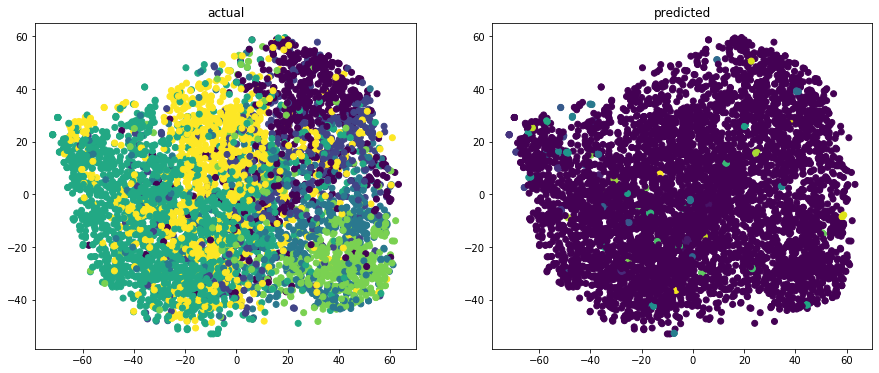

In [60]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('predicted')
ax1.scatter(reduced[:VISUAL_AMOUNT,0], reduced[:VISUAL_AMOUNT,1], c=y_db[:VISUAL_AMOUNT])

ax2 = fig.add_subplot(1,2,1)
ax2.set_title('actual')
ax2.scatter(reduced[:VISUAL_AMOUNT,0], reduced[:VISUAL_AMOUNT,1], c=product_indices[:VISUAL_AMOUNT])

A basic implementation groups everything together in one cluster. Which could indicate we need some hyperparameter tuning. However due to the algorithm being density based. This would not really help finding separated clusters because the data itself doesn't show any clusters, all the data would still be classified as one cluster. Changing some hyperparameters won't affect that.

The only way to make DBscan work is by tranforming the data with different algorithms, instead of working with TSNE.

## 4.3 Testing DBSCAN with other dimensionality-reducing algorithms

Both tfidf and doc2vec were also analyzed. With both of these we didn't seem to find any meaningful clusters, and we ran into similar problems with both of them. The code given below was used to test both methods:

In [61]:
%%script false --no-raise-error
for bigE in range(2,40,2):
    e = bigE/10
    for min in [4,7,10]:
        db = DBSCAN(eps=e,min_samples=min)
        db.fit(x_train)
        print(f"\n\n With e={e} and min={min}:")
        printClusters(db.labels_)
        print(scoringFunc(ground_labels,db.labels_))

There are no graphs to show but we concluded the following:

* tf-idf + truncated svd didn't perform well under most analyzed circumstances. The apparent precision did seem promising at first before we realized everything was grouped under one cluster. Increasing eps and min_samples wasn't effective at all, as soon as eps was about 0.8, there was one very dominant cluster even with min_samples as low as 4. Testing with higher eps and min_samples was therefore unnecesary. Testing with a lower esp yielded at most 2 dominant clusters, with many tiny clusters (sizes 20-50). From this we're concluding that there is probably only one big glob of data with no real clusters
* Similar results appeared when switching to cosine distance.
* d2v + pca had about a similar performance and similar issues arose as with tf-idf and tsvd. The problem was that there were very few clusters, and again there was one dominating cluster influencing the result, even with very low epsilons. This happened both with euclidian and with cosine distance. In this case with very low epsilons there would be one cluster having nearly all samples. And half of the data was classified as outliers.


In both cases, raising the amount of dimensionalities only helped so much before running into the curse of dimentionality problem. We haven't found a distance function that performs well when increasing the dimensionality. in higher dimensions there also seems to be only one main cluster, with the rest being outliers/non meaningful clusters

Below is given a truncated svd example with DBscan in higher dimensions



In [62]:
reducedSVD = tsvd(10)
db = DBSCAN(eps=0.5,min_samples=10)
y_db = db.fit_predict(reducedSVD)
printClusters(db.labels_)
#TP, FP, TN, FN = calculateStatistics(product_indices, db.labels_)
#printStatistics(TP, FP, TN, FN)

Resulting shape: (10000, 10)
cluster 0: 7942 elements
cluster 1: 14 elements
cluster 2: 50 elements
outliers: 1994


similarly with PCA (this time with high min_labels, which means eps sohuld also be raised a bit):

In [63]:
reducedPCA = pca(10)
db = DBSCAN(eps=0.7,min_samples=100)
y_db = db.fit_predict(reducedPCA)
printClusters(db.labels_)
#TP, FP, TN, FN = calculateStatistics(product_indices, db.labels_)
#printStatistics(TP, FP, TN, FN)

Resulting shape: (10000, 10)
cluster 0: 8755 elements
outliers: 1245


From this we're concluding that no matter how we represent and reduce the data, there always seems to be one main blob of data, with no real clusters. We'll come back to this at the conclusion of this sprint.

# 5. HDBscan 



HDBScan extends DBScan by converting it to a hierarchical clustering algorithm. HDBScan is better at dealing with uneven cluster sizes than DBScan. This might be possible with our dataset.
HDBScan is not part of sklearn yet, we used this implementation https://github.com/scikit-learn-contrib/hdbscan

In [76]:
clusterer = HDBSCAN(min_cluster_size=50, metric='l2')
cluster_labels = clusterer.fit_predict(x)
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20])

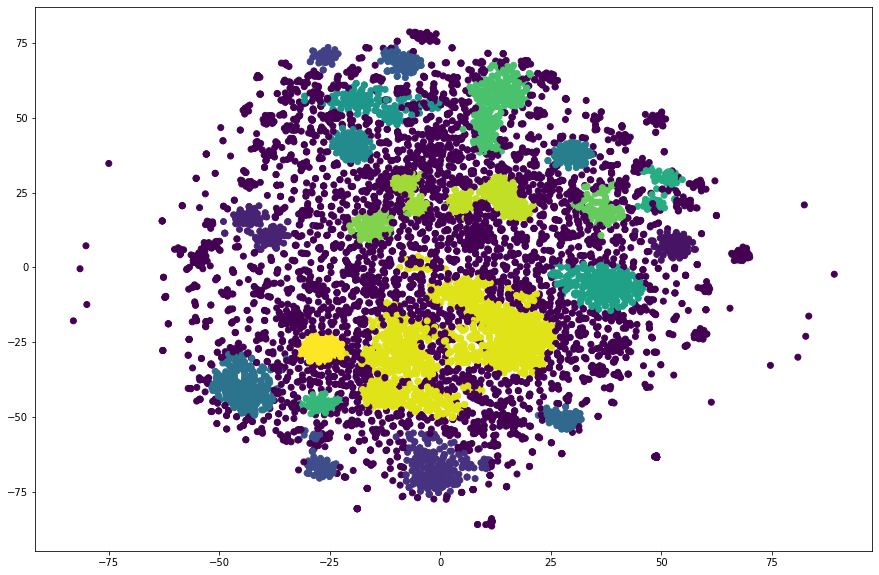

In [77]:
plt.figure(figsize=(15,10))
plt.scatter(x[:,0], x[:,1], c=cluster_labels)

HDBScan does seem to find some clusters. Large parts of dataset are set aside as noise however.

To have an idea of how the hdbscan would perform with different values for the min_cluster_size, the probablilites_ attribute is used. A score is assigned to the cluster. This score is the amount of points that have a probability of less than 5% to be assigned to a cluster. By minimizing this score, more points will be assigned to a cluster. The gaps in the plot point at a stituation where the algorithm cannot distinguish between noise and data. This is also not what we want.
(https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6)

In [72]:
low = 2
high = 50
scores = []
for i in range(low, high):
    hdbscan = HDBSCAN(min_cluster_size=i)
    hdbscan.fit(x)
    count = list(filter(lambda prob: prob < 0.05, hdbscan.probabilities_))
    scores.append(len(count)/x.shape[0])

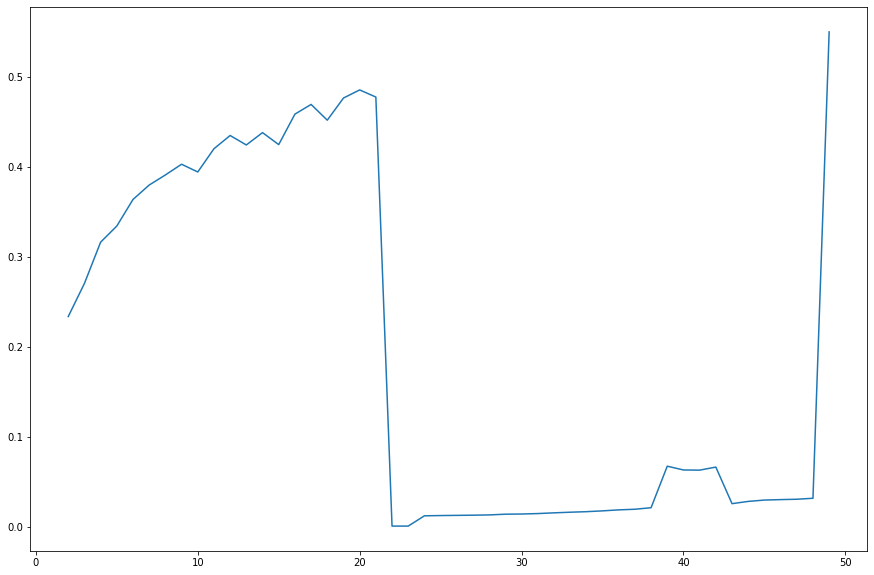

In [73]:
plt.figure(figsize=(15,10))
plt.plot(range(low,high), scores)

# Conclusion

This sprint we quickly went over the algorithm we could use for data reduction and applied kmeans, dbscan, and hdbscan to a tsne-reduced set. We mainly analyzed the clustering part and we didn't pay as much attention as we should to the data reduction part.

In hindsight we should have analyzed what results the dimentionality-reducing algorithms gave, before using them with clustering algorithms. We should have analyzed if the reduced sets seemed to have any interesting properties in two dimensions. And only if so, check if it is worthwile and meaningful to use a cluster algorithm, maybe some reduced sets would even be able to work with standard k-means if we put more effort into reducing the data properly. 

We learnt that next time we have to analyze these algorithms and their results better. We have to analyze the data to see if even it is useful to use clustering algorithms. If doesn't look that interesting, we have to check if there are other possibilities and/or take a better look at their hyperparameters. Instead of assuming it would immediately work out with clustering algorithms. 